In [1]:
import random
import math
import numpy as np
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as nnf

from util import load_Cifar10

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
# define the autoencoder model
# class Autoencoder(nn.Module):
#     def __init__(self, input_size, hidden_size, bottleneck_size, layers):
#         super(Autoencoder, self).__init__()

#         assert(layers >= 2) # the network must have at least 2 layers
#         layers = layers - 2
#         # construct the encoder's interior layers as linear + relu
#         self.encoder = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU()
#             )
#         for i in range(1, layers):
#             self.encoder.add_module(str(2*i), nn.Linear(hidden_size, hidden_size))
#             self.encoder.add_module(str(2*i+1), nn.ReLU())
#         # the output layer is just linear
#         self.encoder.add_module(str(2*layers), nn.Linear(hidden_size, bottleneck_size))

#         # likewise for the decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(bottleneck_size, hidden_size),
#             nn.ReLU()
#             )
#         for i in range(1, layers):
#             self.decoder.add_module(str(2*i), nn.Linear(hidden_size, hidden_size))
#             self.decoder.add_module(str(2*i+1), nn.ReLU())
#         self.decoder.add_module(str(2*layers), nn.Linear(hidden_size, input_size))

#     def encode(self, x):
#         '''map data to code space'''
#         x = self.encoder(x)
#         return x
    
#     def decode(self, x):
#         '''map data from code space back to data space'''
#         x = self.decoder(x)
#         return x

#     def forward(self, x):
#         '''compress and uncompress data (forward function required by pytorch nn.Module)'''
#         x = self.encode(x)
#         x = self.decode(x)
#         return x

# def train_autoencoder(model, X_train, num_epochs=100, batch_size=32, lr=0.001, caption="autoencoder"):
#     # define the loss function and optimizer according to task description
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.MSELoss()
#     # train the model
#     indices = list(range(len(X_train)))
#     for epoch in range(num_epochs):
#         for i in range(0, len(X_train), batch_size):
#             # get a random batch of data
#             random.shuffle(indices)
#             batch = torch.tensor(X_train[indices[i:i+batch_size]], dtype=torch.float32).to(DEVICE)
#             # forward pass
#             output = model.forward(batch)
        #     loss = criterion(output, batch)

        #     # backpropagation
        #     optimizer.zero_grad()
        #     loss.backward()
        #     optimizer.step()
        # # print the loss every 10 epochs
        # if (epoch+1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [3]:
# Load the digits dataset
#digits = load_digits()
# Split the dataset into train and test sets
#X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)
# Scale the data
#scaler = StandardScaler()
#X_train_digits = scaler.fit_transform(X_train_digits)
#X_test_digits = scaler.transform(X_test_digits)

In [4]:
# def plot_digits_reconstructions(model, X_test, title=""):
#     # reconstruct the test set
#     with torch.no_grad():
#         decoded = model.forward(torch.tensor(X_test, dtype=torch.float32)).to("cpu")
#     # plot the original and reconstructed test set
#     fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(10, 2))
#     fig.suptitle("Originals (top), differences (center), and reconstructions (bottom)" + title)
#     for i in range(10):
#         # normalize decoded by the inter-quartile range (IQR) of X_test
#         # to make the difference more meaningful
#         qt1, qt3 = np.quantile(X_test[i], [0.25, 0.75])
#         qd1, qd3 = np.quantile(decoded[i], [0.25, 0.75])
#         iqr_ratio = (qt3 - qt1) / (qd3 - qd1)
#         decoded[i] = decoded[i] * iqr_ratio
#         # compute the difference between the original and reconstructed image
#         diff = X_test[i] - decoded[i].numpy()
#         # plot the original, difference, and reconstructed image
#         axes[0][i].imshow(X_test[i].reshape(8, 8), cmap='gray')
#         axes[1][i].imshow(diff.reshape(8, 8), cmap='gray')
#         axes[2][i].imshow(decoded[i].reshape(8, 8), cmap='gray')
#         # remove axis ticks for images
#         for k in range(3):
#             axes[k][i].set_xticks([])
#             axes[k][i].set_yticks([])

In [5]:
# train an autoencoder with bottleneck size 2 (note: data dimension is 64=8x8)
#model_digits_2 = Autoencoder(input_size=X_train_digits.shape[1], hidden_size=64, bottleneck_size=2, layers=5).to(DEVICE)
#train_autoencoder(model_digits_2, X_train_digits, num_epochs=1000, batch_size=256, lr=0.001)
#model_digits_2 = model_digits_2.to("cpu")
#plot_digits_reconstructions(model_digits_2, X_test_digits, ", bottleneck size 2")

In [6]:
class ConvEncoder(nn.Module):
    def __init__(self, input_channels, base_channels, num_layers):
        """
        Args:
            input_channels (int): number of channels in the input image (e.g., 1 for grayscale, 3 for RGB).
            base_channels (int): number of filters in the first conv layer.
            num_layers (int): total number of conv layers.
        """
        super(ConvEncoder, self).__init__()
        layers = []
        in_channels = input_channels
        # We use a constant kernel size, stride, and padding.
        kernel_size = 3
        stride = 2  # downsampling by a factor of 2 each time
        padding = 1
        
        for i in range(num_layers):
            out_channels = base_channels * (2 ** i)
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                                    stride=stride, padding=padding))
            layers.append(nn.ReLU())
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)

class ConvDecoder(nn.Module):
    def __init__(self, output_channels, base_channels, num_layers):
        """
        Args:
            output_channels (int): number of channels in the output image.
            base_channels (int): should match the encoder's base_channels.
            num_layers (int): total number of conv transpose layers.
        """
        super(ConvDecoder, self).__init__()
        layers = []
        # Start with the number of channels at the bottleneck (last encoder layer)
        in_channels = base_channels * (2 ** (num_layers - 1))
        kernel_size = 3
        stride = 2  # upsampling by a factor of 2 each time
        padding = 1
        output_padding = 1  # usually needed to exactly invert the spatial dimension reduction

        # Reverse the process of the encoder.
        for i in range(num_layers - 1, 0, -1):
            out_channels = base_channels * (2 ** (i - 1))
            layers.append(nn.ConvTranspose2d(in_channels, out_channels,
                                             kernel_size=kernel_size, stride=stride,
                                             padding=padding, output_padding=output_padding))
            layers.append(nn.ReLU())
            in_channels = out_channels

        # Final layer to get back to the desired output channels.
        layers.append(nn.ConvTranspose2d(in_channels, output_channels,
                                         kernel_size=kernel_size, stride=stride,
                                         padding=padding, output_padding=output_padding))
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)

class ConvAutoencoder(nn.Module):
    def __init__(self, input_channels, output_channels, base_channels, num_layers):
        super(ConvAutoencoder, self).__init__()
        self.encoder = ConvEncoder(input_channels, base_channels, num_layers)
        self.decoder = ConvDecoder(output_channels, base_channels, num_layers)
        self.loss = []
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

In [7]:
x_dim = 32
channels = 3

scale_factor = 2
x_inp_dim  = int(x_dim / scale_factor)


hidden_dim = 512

lr = 1e-3
epochs = 3000
batch_size = 1500

train_dataset, test_dataset, train_loader, test_loader, classes = load_Cifar10(batch_size, [1])
num_train_data = len(train_dataset)

In [8]:
model = ConvAutoencoder(input_channels=3, output_channels=3, base_channels=64, num_layers=5).to(DEVICE)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
# train the model
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x_inp = nnf.interpolate(x, size=(x_inp_dim, x_inp_dim), mode='bicubic', align_corners=False)
        x_inp = x_inp.to(DEVICE)

        x = x.to(DEVICE)
        optimizer.zero_grad()

        x_hat = model.forward(x_inp)

        loss = criterion(x_hat, x)
        overall_loss += loss.item() / num_train_data
        # backpropagation
        loss.backward()
        optimizer.step()
    # print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    model.loss.append(overall_loss)

Epoch [10/3000], Loss: 0.0698
Epoch [20/3000], Loss: 0.0486
Epoch [30/3000], Loss: 0.0405
Epoch [40/3000], Loss: 0.0380
Epoch [50/3000], Loss: 0.0346
Epoch [60/3000], Loss: 0.0320
Epoch [70/3000], Loss: 0.0302
Epoch [80/3000], Loss: 0.0287
Epoch [90/3000], Loss: 0.0321
Epoch [100/3000], Loss: 0.0287
Epoch [110/3000], Loss: 0.0262
Epoch [120/3000], Loss: 0.0258
Epoch [130/3000], Loss: 0.0261
Epoch [140/3000], Loss: 0.0240
Epoch [150/3000], Loss: 0.0250
Epoch [160/3000], Loss: 0.0229
Epoch [170/3000], Loss: 0.0229
Epoch [180/3000], Loss: 0.0221
Epoch [190/3000], Loss: 0.0214
Epoch [200/3000], Loss: 0.0207
Epoch [210/3000], Loss: 0.0203
Epoch [220/3000], Loss: 0.0193
Epoch [230/3000], Loss: 0.0190
Epoch [240/3000], Loss: 0.0185
Epoch [250/3000], Loss: 0.0183
Epoch [260/3000], Loss: 0.0179
Epoch [270/3000], Loss: 0.0178
Epoch [280/3000], Loss: 0.0178
Epoch [290/3000], Loss: 0.0168
Epoch [300/3000], Loss: 0.0172
Epoch [310/3000], Loss: 0.0172
Epoch [320/3000], Loss: 0.0166
Epoch [330/3000],

[]

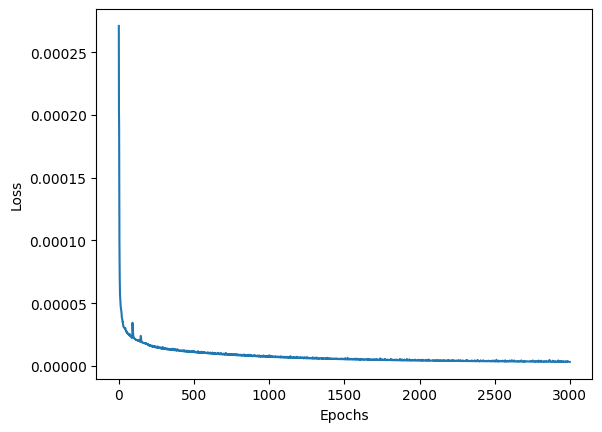

In [10]:
plt.plot(model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [11]:
from tqdm import tqdm
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x_inp = nnf.interpolate(x, size=(x_inp_dim, x_inp_dim), mode='bicubic', align_corners=False)
        x_inp = x_inp.to(DEVICE)

        x = x.to(DEVICE)

        x_hat = model(x_inp)

        break

  0%|          | 0/1 [00:03<?, ?it/s]


In [12]:
def show_image(x, x_inp, x_hat, n):


    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        axs[0, i].imshow(x[i].permute(1, 2, 0).cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(x_inp[i].permute(1, 2, 0).cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(x_hat[i].permute(1, 2, 0).cpu().numpy())
        axs[2, i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011979165..1.0094516].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18478622..1.2728091].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07986452..1.1315296].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0991843..1.0283701].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.039626203..1.1811472].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00048636692..0.894581].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0

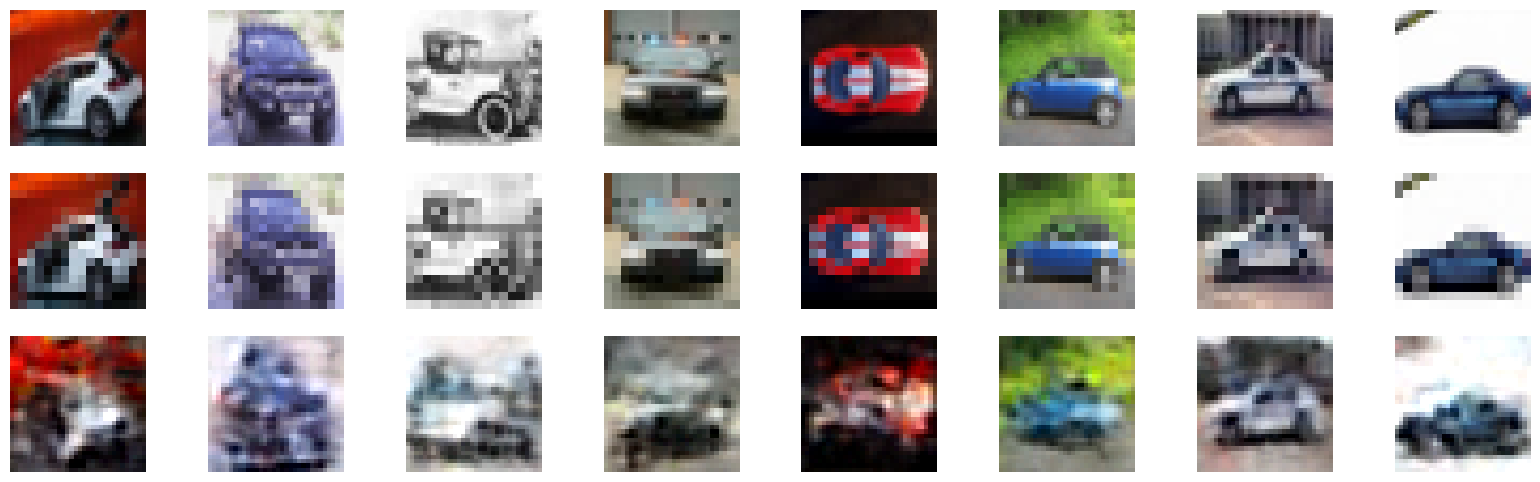

In [13]:
show_image(x, x_inp, x_hat, 8)

In [14]:
torch.save(model.state_dict(), "CIFAR11.pth")